In [1]:
#importing neccessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 


import os
import sys
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from log import get_logger  
file_handler = FileHandler()
my_logger = get_logger("LSTM_Modeling")  

In [3]:
train_data = file_handler.read_csv("../data/cleaned_train.csv") 

2022-09-10 18:28:50,440 — FileHandler — DEBUG — file read as csv


### Isolate the Rossmann Store Sales Dataset into Time Series Data

In [4]:
data = train_data.groupby("Date").agg({"Sales": "mean"})
data.head(10)

,Sales
Date,
2013-01-01,84.395871
2013-01-02,6178.517489
2013-01-03,5660.173094
2013-01-04,5923.138117
2013-01-05,5299.049327
2013-01-06,119.357848
2013-01-07,9377.999103
2013-01-08,7742.737220
2013-01-09,6887.256502


### Check if the Time Series Data is Stationary

In [5]:
adfResult = adfuller(data.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.751282394418177
p-value: 5.958430360162185e-07


Since the p-value is less than 0.05, the data is not Stationary.

In [6]:
scaler = MinMaxScaler()

try:
    scaler.fit(data.Sales.values.reshape([-1, 1]))
    scaled_array = scaler.transform(data.Sales.values.reshape(-1, 1))
    data['SalesScaled'] = scaled_array
    data.tail(10)

    my_logger.debug("Data scaled successfully.")

except Exception as e:
    my_logger.exception(f"Scaling error, {e}")

2022-09-10 18:29:09,020 — LSTM_Modeling — DEBUG — Data scaled successfully.


In [7]:
# Check if Scaled Sales is Stationary

adfResult = adfuller(data.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.751282394418176
p-value: 5.958430360162239e-07


### Differencing the Time Series Data

In [8]:
# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

salesScaledDiff = difference(data.SalesScaled.values)
salesScaledDiff

0      0.506975
1     -0.043121
2      0.021876
3     -0.051918
4     -0.430903
         ...   
936    0.760631
937   -0.108573
938   -0.043412
939    0.022197
940    0.089605
Length: 941, dtype: float64

### Making the Data ready for Modeling

In [9]:
SIZE = len(data.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE = SIZE - WINDOW_SIZE * 2
EPOCHS = 200

In [10]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [11]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [12]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [13]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)

In [15]:
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [16]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [17]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [18]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Model Building

In [19]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [20]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 122s 122s/step - loss: 0.1271 - val_loss: 0.1331
Epoch 2/200
1/1 [==============================] - 0s 388ms/step - loss: 0.1222 - val_loss: 0.1279
Epoch 3/200
1/1 [==============================] - 1s 649ms/step - loss: 0.1174 - val_loss: 0.1229
Epoch 4/200
1/1 [==============================] - 1s 547ms/step - loss: 0.1128 - val_loss: 0.1180
Epoch 5/200
1/1 [==============================] - 1s 518ms/step - loss: 0.1083 - val_loss: 0.1133
Epoch 6/200
1/1 [==============================] - 0s 453ms/step - loss: 0.1040 - val_loss: 0.1088
Epoch 7/200
1/1 [==============================] - 0s 342ms/step - loss: 0.0998 - val_loss: 0.1044
Epoch 8/200
1/1 [==============================] - 1s 764ms/step - loss: 0.0958 - val_loss: 0.1001
Epoch 9/200
1/1 [==============================] - 0s 424ms/step - loss: 0.0918 - val_loss: 0.0960
Epoch 10/200
1/1 [==============================] - 1s 548ms/step - loss: 0.0880 - val_loss: 0.0919
Epoch 11

1/1 [==============================] - 0s 397ms/step - loss: 0.0281 - val_loss: 0.0270
Epoch 84/200
1/1 [==============================] - 0s 316ms/step - loss: 0.0281 - val_loss: 0.0270
Epoch 85/200
1/1 [==============================] - 0s 472ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 86/200
1/1 [==============================] - 0s 349ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 87/200
1/1 [==============================] - 0s 407ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 88/200
1/1 [==============================] - 0s 347ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 89/200
1/1 [==============================] - 0s 372ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 90/200
1/1 [==============================] - 0s 334ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 91/200
1/1 [==============================] - 0s 376ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 92/200
1/1 [==============================] - 0s 376ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 93/200


1/1 [==============================] - 0s 492ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 165/200
1/1 [==============================] - 0s 433ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 166/200
1/1 [==============================] - 0s 483ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 167/200
1/1 [==============================] - 1s 502ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 168/200
1/1 [==============================] - 0s 412ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 169/200
1/1 [==============================] - 0s 342ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 170/200
1/1 [==============================] - 0s 320ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 171/200
1/1 [==============================] - 0s 319ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 172/200
1/1 [==============================] - 0s 312ms/step - loss: 0.0280 - val_loss: 0.0268
Epoch 173/200
1/1 [==============================] - 0s 308ms/step - loss: 0.0279 - val_loss: 0.0268
Epoc

In [21]:
loss = model.evaluate(DatasetVal, verbose=1)
t_loss = model.evaluate(DatasetTrain, verbose=1)

1/1 [==============================] - 0s 304ms/step - loss: 0.0279


In [22]:
print("Training loss = %f" % (t_loss))
print("Validation loss = %f" % (loss))

Training loss = 0.027895
Validation loss = 0.026755


In [23]:
from time import gmtime, strftime

time = strftime("%Y-%m-%d", gmtime())

In [25]:
model.save(f'../models/LSTM_sales_prediction_model {time}.pkl')

INFO:tensorflow:Assets written to: ../models/LSTM_sales_prediction_model 2022-09-10.pkl\assets


INFO:tensorflow:Assets written to: ../models/LSTM_sales_prediction_model 2022-09-10.pkl\assets


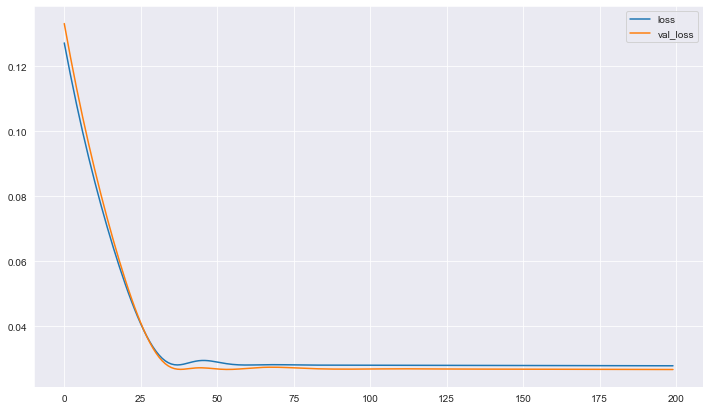

In [27]:
fig = plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

#### Model Prediction

In [28]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Forecast = model_forecast(model, data.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))
 

1/1 [==============================] - 160s 160s/step


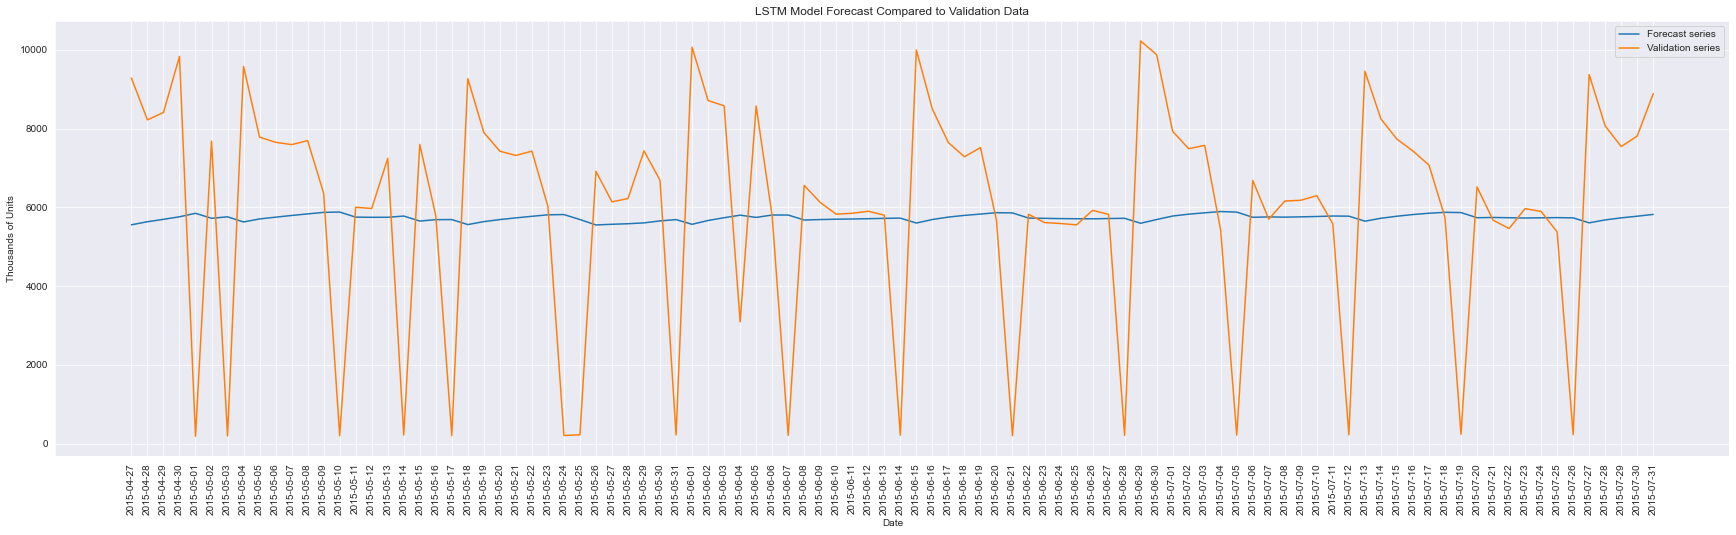

In [29]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")